In [1]:
import os
from control.matlab import ss, lsim, linspace, c2d
from PID import PID
from sim3 import vt,dc,ap
import matplotlib.pyplot as plt
import numpy as np
import time
import statistics

In [58]:
# you can use vt, dc and ap
a = vt()
print(a.sysd)
a.thres=3

A = [[0.84648172]]

B = [[0.09211097]]

C = [[1.]]

D = [[0.]]

dt = 0.02



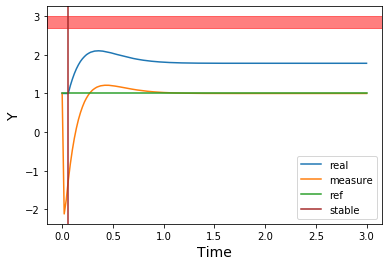

In [59]:
#only for vt
control_inputs = []
measures=[]
x_just_before = 0
xout=1
pid = PID(P=a.p, I=a.i, D=a.d, current_time=0)
pid.setWindup(100)
pid.setSampleTime(a.Ts)
for i in range(0, a.slot+1):
    a.y_real_arr.append(a.yreal)
    # sensor attack here
    a.score.append(a.s)
    pid.SetPoint = a.ref[i]
    pid.update(feedback_value=a.ymeasure, current_time=i * a.Ts)
    a.cin = pid.output
#     print(a.ymeasure,i,a.cin,xout)
    if a.cin>5:
        a.cin=5
    elif a.cin<-5:
        a.cin = -5
    else:
        a.cin=a.cin
    control_inputs.append(a.cin)
    if i>a.place:
        if (a.score[-1]==a.thres):
            a.att=a.drift
        else:
            a.att = a.thres+a.drift-a.score[-1]
    
    yout, T, xout = lsim(a.sysc, a.cin, [0, a.Ts], a.ymeasure)
    ymax, T, xout1 = lsim(a.sysc, a.maxc, [0, a.Ts], a.ymeasure)
    yout2, T, xout2 = lsim(a.sysc, a.cin, [0, a.Ts], a.yreal)
    a.yreal=yout2[-1]
    ypred = yout[-1]
    a.ymeasure = yout[-1]-a.att
#     if i>a.place-1:
#         a.ymeasure = min(ymax[-1],yout[-1]-a.att)
#         print(a.ymeasure,a.cin)
    a.s = a.score[-1]+abs(ypred-a.ymeasure)-a.drift
    if(a.s<0):
        a.s=0
    if(i==a.place+1):
        x_just_before = xout
    measures.append(a.ymeasure)

# print(control_inputs[a.place+2:])
# print(a.score[a.place+2:])
# print(x_just_before)
plt.plot(a.t_arr[350:]-7, a.y_real_arr[350:],label='real')
plt.plot(a.t_arr[350:]-7, measures[350:],label='measure')
plt.plot(a.t_arr[350:]-7, a.ref[350:],label='ref')
plt.axhspan(2.7, 3.0, color='r', alpha=0.5)
plt.axvline(x=(a.place+2+k)*a.Ts-7, color='brown',label='stable')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.legend()
plt.show()

In [60]:
# ---------------------------------------
max_k = 450
attack_inputs = control_inputs[a.place+2:]
for j in range(0, len(attack_inputs)-10):
    temp = attack_inputs[j:j+10]
    vari = statistics.variance(temp)
    print(vari, end= ' ')
    if(vari < 1e-8):
        max_k = j
        break
print('max_k', max_k)

attack_inputs = np.array([control_inputs[a.place+2:]])
x_just_before = x_just_before[-1]
print(x_just_before, len(x_just_before.shape))
if len(x_just_before.shape) == 0:
    x_a = np.array([[x_just_before]])
else:
    x_a = np.array([[item] for item in x_just_before])
# def get_safetime(self, x_a, safe_set_lo, safe_set_up, control_list: np.array, max_k)
safe_set_lo = a.safeset['lo']
safe_set_up = a.safeset['up']
k = a.est.get_safetime(x_a, safe_set_lo, safe_set_up, attack_inputs, max_k)
print(k)

# ---------------------------------------
        


0.46958638766097455 0.00250546778420609 0.003722086198604006 0.0070567773336808175 0.008656605188989532 0.011807765856741622 0.012940903195902732 0.014745776161672997 0.01532786304732379 0.0168862307908804 0.014810754808469986 0.015681317957234344 0.013140985162531923 0.013537512777719465 0.010970836442528862 0.011075648541979729 0.008746273270303617 0.008692207396805172 0.006722445649374719 0.00659656773566027 0.005013922558523824 0.004868115373373414 0.0036456173417696255 0.003507516407113047 0.0027606960527419566 0.002470515131522871 0.0019117146836053615 0.0016964075475879052 0.0012885276178484317 0.0011321504445660742 0.0008405542684842204 0.0007289658704446801 0.0005241628817891805 0.0004456951471440419 0.00041356050450778244 0.00028953263200957315 0.00026720213933321437 0.00018547879185525171 0.0001702662500639626 0.00011719642919404368 0.00010701849321674231 7.710573816408602e-05 6.673179267295287e-05 4.7469841623095335e-05 4.0762351018361066e-05 2.8492516700224637e-05 2.418876

In [5]:
a.slot

500

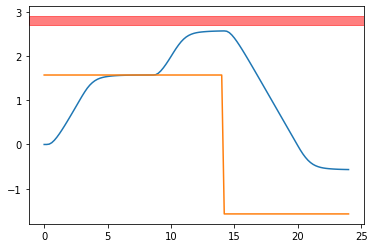

In [11]:
plt.plot(a.t_arr, a.y_real_arr, a.t_arr, a.ref)
plt.axhspan(2.7, 3.5, color='r', alpha=0.5)
plt.show()

In [6]:
a=dc()

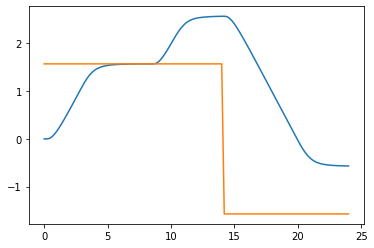

In [7]:
#for ap and dc
control_inputs = []
x_just_before = 0
pid = PID(P=a.p, I=a.i, D=a.d, current_time=0)
pid.setWindup(100)
pid.setSampleTime(a.Ts)
for i in range(0, a.slot+1):
    a.y_real_arr.append(a.yreal)
    # sensor attack here
    a.score.append(a.s)
    pid.SetPoint = a.ref[i]
#     print(a.ymeasure,i * a.Ts)
    pid.update(feedback_value=a.ymeasure, current_time=i * a.Ts)
    a.cin = pid.output

    if a.cin>5:
        a.cin=5
    elif a.cin<-5:
        a.cin = -5
    else:
        a.cin=a.cin
    control_inputs.append(a.cin)
    if i>a.place:
        if (a.score[-1]==a.thres):
            a.att=a.drift
        else:
            a.att = a.thres+a.drift-a.score[-1]
            x_just_before = xout 
    yout, T, xout = lsim(a.sysd, a.cin, [0, a.Ts], a.xmeasure)
    yout2, T, xout2 = lsim(a.sysd, a.cin, [0, a.Ts], a.xreal)
    a.yreal=yout2[-1]
    ypred = yout[-1]
    a.xmeasure = xout[-1, :].T
    a.xreal = xout2[-1, :].T
    a.ymeasure = yout[-1]-a.att
#     if i>a.place:
#         a.ymeasure = min(ymax[-1],yout[-1]-a.att)
    a.s = a.score[-1]+abs(ypred-a.ymeasure)-a.drift
    if(a.s<0):
        a.s=0
plt.plot(a.t_arr, a.y_real_arr, a.t_arr, a.ref)
plt.show()
#waht you need
# print(control_inputs)
# print(x_just_before)